# Podcast Reviews: Data Exploration and Feature Engineering

This notebook performs exploratory data analysis and feature engineering on the [Podcast Reviews dataset from Kaggle](https://www.kaggle.com/datasets/thoughtvector/podcastreviews). The preprocessed data will be used to build a collaborative filtering recommendation system in a separate notebook.

## Approach

Our methodology consists of the following steps:

1. **Exploratory Data Analysis (EDA)** - Examine the dataset structure, identify active users, and understand review distribution patterns
2. **Data Preprocessing** - Filter active users (3+ reviews) and encode categorical variables
3. **Feature Engineering** - Generate semantic embeddings using BERT-based sentence transformers to capture review sentiment and content
4. **Train/Test Split** - Create temporal data splits and save processed data for model training

## Dataset

The Podcast Reviews dataset contains over 5 million reviews with the following attributes:
- User reviews and review titles
- User ratings
- Podcast and user identifiers  
- Review timestamps


In [ ]:
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from huggingface_hub import login
import pyarrow.parquet as pq
import pyarrow as pa
import gc
import shutil
import pickle
import os

from config import Config

## 1. Exploratory Data Analysis and Data Loading

In [ ]:
# Create DuckDB connection
conn = duckdb.connect()

In [ ]:
# Describe data set
conn.execute(f"""
    DESCRIBE SELECT * FROM read_json_auto('{Config.DATA_DIR}')
"""
).df()


,column_name,column_type,null,key,default,extra
0,podcast_id,VARCHAR,YES,None,None,None
1,title,VARCHAR,YES,None,None,None
2,content,VARCHAR,YES,None,None,None
3,rating,BIGINT,YES,None,None,None
4,author_id,VARCHAR,YES,None,None,None
5,created_at,VARCHAR,YES,None,None,None


In [ ]:
# General statistics
query = f"""
SELECT
    COUNT(*) as total_reviews,
    COUNT(DISTINCT author_id) as total_users,
    COUNT(DISTINCT podcast_id) as total_podcasts,
    AVG(rating) as avg_rating,
    AVG(LENGTH(content)) as avg_content_length -- Added average content length
FROM read_json_auto('{Config.DATA_DIR}')
WHERE rating IS NOT NULL AND content IS NOT NULL
"""

ans = conn.execute(query).df()

print(f"Total reviews (with text): {ans['total_reviews'].iloc[0]:,}")
print(f"Total users: {ans['total_users'].iloc[0]:,}")
print(f"Total podcasts: {ans['total_podcasts'].iloc[0]:,}")
print(f"Average rating: {ans['avg_rating'].iloc[0]:.2f}")
print(f"Average content length: {ans['avg_content_length'].iloc[0]:.2f} characters") # Display average content length

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total reviews (with text): 5,607,021
Total users: 3,256,501
Total podcasts: 303,911
Average rating: 4.65
Average content length: 227.07 characters


### Checking for Null Values
We verify data completeness by checking for null entries across all columns.

In [ ]:
# Find null entries
query = f"""
SELECT
    COUNT(*) - COUNT(podcast_id) as null_podcast_id,
    COUNT(*) - COUNT(title) as null_title,
    COUNT(*) - COUNT(content) as null_content,
    COUNT(*) - COUNT(rating) as null_rating,
    COUNT(*) - COUNT(author_id) as null_author_id,
    COUNT(*) - COUNT(created_at) as null_created_at,
    COUNT(*) as total_rows
FROM read_json_auto('{Config.DATA_DIR}')
"""

conn.execute(query).df()

,null_podcast_id,null_title,null_content,null_rating,null_author_id,null_created_at,total_rows
0,0,0,0,0,0,0,5607021


### Checking for Empty Strings and Whitespace

Beyond null values, we check for empty strings or whitespace-only entries that could affect data quality.


In [ ]:
# Find empty string and whitespace-only entries
query = f"""
SELECT
    SUM(CASE WHEN TRIM(podcast_id) = '' THEN 1 ELSE 0 END) as empty_podcast_id,
    SUM(CASE WHEN TRIM(author_id) = '' THEN 1 ELSE 0 END) as empty_author_id,
    SUM(CASE WHEN TRIM(content) = '' THEN 1 ELSE 0 END) as whitespace_content,
    SUM(CASE WHEN TRIM(title) = '' THEN 1 ELSE 0 END) as whitespace_title,
    SUM(CASE WHEN TRIM(content) = '' AND TRIM(title) = '' THEN 1 ELSE 0 END) as white_title_and_content
FROM read_json_auto('{Config.DATA_DIR}')
"""

conn.execute(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,empty_podcast_id,empty_author_id,whitespace_content,whitespace_title,white_title_and_content
0,0.0,0.0,6.0,27.0,2.0


### Data Quality Decisions

We identified 2 reviews with both empty title and content. These will be excluded from the training set, which is acceptable given we have over 5 million valid reviews available.

Below is an example of a review entry:

In [ ]:
# Let us see an example.
query = f"""
SELECT *
FROM read_json_auto('{Config.DATA_DIR}')
WHERE title IS NOT NULL AND content IS NOT NULL
USING SAMPLE 1 ROWS
"""

# Set display option to show full content
pd.options.display.max_colwidth = None
conn.execute(query).df()


,podcast_id,title,content,rating,author_id,created_at
0,a423a3390e4eb3d4c5367221e21196a3,Obsessed,So good!,5,e03980676dd370e,2016-02-20 02:08:41+00


### User Activity Distribution

We analyze how many reviews each user has written to understand user engagement levels and identify active users.


In [ ]:
# Explore the distribution of reviews per user
query = f"""
SELECT
    reviews_per_user,
    COUNT(*) as num_users
FROM (
    SELECT
        author_id,
        COUNT(*) as reviews_per_user
    FROM read_json_auto('{Config.DATA_DIR}')
    WHERE title IS NOT NULL AND content IS NOT NULL
    GROUP BY author_id
)
GROUP BY reviews_per_user
ORDER BY reviews_per_user
"""

ans = conn.execute(query).df()
print("\nReviews per User Distribution:")
# Set display option to suppress scientific notation
pd.options.display.float_format = '{:,.0f}'.format
display(ans.head(5))
print(f"\n\nUsers with 3+ reviews: {ans[ans['reviews_per_user']>=3]['num_users'].sum():,}")
print(f"\nUsers with 10+ reviews: {ans[ans['reviews_per_user']>10]['num_users'].sum():,}")
print(f"\nTotal Users: {ans[ans['reviews_per_user']>=1]['num_users'].sum():,}\n")
print("\nSummary Statistics:")
ans['reviews_per_user'].describe()


Reviews per User Distribution:


,reviews_per_user,num_users
0,1,2400918
1,2,457374
2,3,166691
3,4,79668
4,5,44877




Users with 3+ reviews: 398,209

Users with 10+ reviews: 32,737

Total Users: 3,256,501


Summary Statistics:


,reviews_per_user
count,270
mean,195
std,233
min,1
25%,68
50%,136
75%,224
max,"1,681"


### Active User Insights

Out of 3.2 million total users, approximately 400,000 (12%) have written 3 or more reviews. While this represents a small fraction of users, these active users contribute roughly 41% of all reviews, making them valuable for building a collaborative filtering model.

In [ ]:
# Calculate percentage of reviews given by active (3+ reviews) users
query = f"""
SELECT
    SUM(CASE WHEN review_count >= 3 THEN review_count ELSE 0 END) * 100.0 / SUM(review_count) as pct_reviews
FROM (
    SELECT author_id, COUNT(*) as review_count
    FROM read_json_auto('{Config.DATA_DIR}')
    WHERE title IS NOT NULL AND content IS NOT NULL
    GROUP BY author_id
)
"""

ans = conn.execute(query).df()
print("\nReview Coverage:")
print(f"Users with 3+ reviews: 12% of users")
print(f"But they contribute: {ans['pct_reviews'].iloc[0]:.1f}% of all reviews!")



Review Coverage:
Users with 3+ reviews: 12% of users
But they contribute: 40.9% of all reviews!


### Visualizing Review Distribution by User Activity

The following pie chart illustrates the proportion of reviews contributed by active users (3+ reviews) versus non-active users (fewer than 3 reviews).


,user_type,num_users,total_reviews
0,Non-Active Users (< 3 Reviews),2858292,"3,315,666"
1,Active Users (3+ Reviews),398209,"2,291,355"


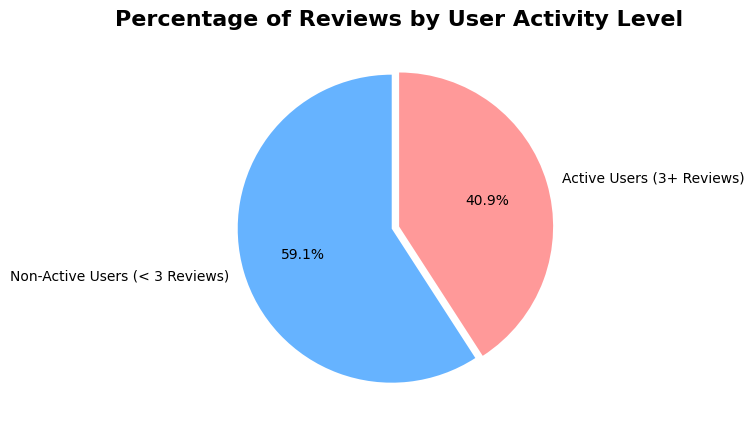

In [ ]:
# Calculate total reviews for active (>=3 reviews) and non-active (<=2 reviews) users
query = f"""
WITH user_review_counts AS (
    SELECT
        author_id,
        COUNT(*) as reviews_per_user
    FROM read_json_auto('{Config.DATA_DIR}')
    WHERE title IS NOT NULL AND content IS NOT NULL
    GROUP BY author_id
)
SELECT
    CASE
        WHEN reviews_per_user >= 3 THEN 'Active Users (3+ Reviews)'
        ELSE 'Non-Active Users (< 3 Reviews)'
    END as user_type,
    COUNT(*) as num_users,
    SUM(reviews_per_user) as total_reviews
FROM user_review_counts
GROUP BY user_type
"""

ans = conn.execute(query).df()
display(ans)

# Prepare data for pie chart
labels = ans['user_type']
sizes = ans['total_reviews']
colors = ['#66b3ff','#ff9999']
# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0))
plt.title('Percentage of Reviews by User Activity Level', fontsize=16, fontweight='bold')
plt.show()

## 2. Data Preprocessing and Feature Engineering

In this section, we filter the dataset to include only active users (3+ reviews), encode categorical variables, and generate semantic embeddings from review text using a BERT-based model. We leverage DuckDB throughout the pipeline to minimize memory usage.

In [ ]:
# Filter active users (3+ reviews) directly in DuckDB and save to Parquet
# This avoids loading the full dataset into memory

query = f"""
WITH user_review_counts AS (
    SELECT
        author_id,
        COUNT(*) as review_count
    FROM read_json_auto('{Config.DATA_DIR}')
    GROUP BY author_id
),
active_users AS (
    SELECT author_id
    FROM user_review_counts
    WHERE review_count >= 3
)
SELECT r.*
FROM read_json_auto('{Config.DATA_DIR}') r
INNER JOIN active_users au ON r.author_id = au.author_id
"""

# Load filtered dataset
reviews_df = conn.execute(query).df()
total_count = len(reviews_df)

# Get statistics
print(f"\nFiltered dataset loaded into memory.")
print(f"Total reviews: {total_count:,}")
print(f"Active users (3+ reviews): {reviews_df['author_id'].nunique():,}")
print(f"Podcasts: {reviews_df['podcast_id'].nunique():,}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Filtered dataset loaded into memory.
Total reviews: 2,291,355
Active users (3+ reviews): 398,209
Podcasts: 182,005


### Encoding Categorical Variables

We encode `author_id` and `podcast_id` as integers using label encoding. This converts the string identifiers into numeric format suitable for machine learning models.


In [ ]:
# Fit encoders on unique values (memory efficient)
unique_users = reviews_df['author_id'].unique()
unique_podcasts = reviews_df['podcast_id'].unique()

user_encoder = LabelEncoder()
podcast_encoder = LabelEncoder()

user_encoder.fit(unique_users)
podcast_encoder.fit(unique_podcasts)

del unique_users, unique_podcasts
gc.collect()

# Add encoded columns
reviews_df['auth_id_encoded'] = user_encoder.transform(reviews_df['author_id'])
reviews_df['podcast_id_encoded'] = podcast_encoder.transform(reviews_df['podcast_id'])

reviews_df.head(1)

,podcast_id,title,content,rating,author_id,created_at,auth_id_encoded,podcast_id_encoded
0,52e3d2c4fab4e80a8bb75ad144671d96,Argh,What the heck is this show? And why can’t I delete it from my feed. It just won’t die!,1,a23655ce5565f32,2019-05-01 01:24:01+00,252026,58639


### Generating BERT Embeddings

We generate text embeddings using the **all-MiniLM-L6-v2** model from Sentence Transformers. This lightweight BERT-based model is fast enough for local experimentation while providing good quality semantic representations of review text.


In [ ]:
# Login with token
login(token=Config.HF_TOKEN)
# Load BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Loaded model: all-MiniLM-L6-v2")
print(f"Embedding dimension: {bert_model.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: all-MiniLM-L6-v2
Embedding dimension: 384


### Combining Text Fields

We combine the review title and content into a single text field to capture richer context before generating embeddings.

In [ ]:
# Combine title and content for richer context
def create_review_text(row):
    """Combine title and content for encoding"""
    parts = []
    if pd.notna(row.get('title')) and str(row['title']).strip():
        parts.append(str(row['title']))
    if pd.notna(row.get('content')) and str(row['content']).strip():
        parts.append(str(row['content']))
    return ". ".join(parts) if parts else "No content"

reviews_df['review_text'] = reviews_df.apply(create_review_text, axis=1)

display(reviews_df.head(1))

,podcast_id,title,content,rating,author_id,created_at,auth_id_encoded,podcast_id_encoded,review_text
0,52e3d2c4fab4e80a8bb75ad144671d96,Argh,What the heck is this show? And why can’t I delete it from my feed. It just won’t die!,1,a23655ce5565f32,2019-05-01 01:24:01+00,252026,58639,Argh. What the heck is this show? And why can’t I delete it from my feed. It just won’t die!


### Processing Embeddings in Chunks

Generating embeddings for over 2 million reviews is memory-intensive, so we process the data in chunks of 50,000 reviews at a time and save the results to Parquet format.


In [ ]:
chunk_size = 50000  # Process 50K reviews at a time to avoid memory issues
num_rows = len(reviews_df)
num_chunks = (num_rows + chunk_size - 1) // chunk_size
embedding_dim = bert_model.get_sentence_embedding_dimension()

print(f"Processing {num_rows:,} reviews in {num_chunks} chunks of {chunk_size:,}")
print(f"Embedding dimension: {embedding_dim}")

# Reset index for clean chunking, create temporary directory to store vectors
reviews_df = reviews_df.reset_index(drop=True)
temp_dir = Path('temp_bert_chunks')
temp_dir.mkdir(exist_ok=True)

# Process review texts in chunks
for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, num_rows)

    print(f"--- Chunk {chunk_idx+1}/{num_chunks} (rows {start_idx:,}-{end_idx-1:,}) ---")

    # Get chunk data and encode with BERT, then add embeddings to chunk
    chunk_df = reviews_df.iloc[start_idx:end_idx].copy()
    texts = chunk_df['review_text'].tolist()

    # Encode texts with Bert
    embeddings = bert_model.encode(
        texts,
        batch_size=128,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    # Add embeddings to chunk
    chunk_df['bert_embedding_all-MiniLM-L6-v2'] = list(embeddings)

    # Save chunk to Parquet and free memory
    chunk_file = temp_dir / f'chunk_{chunk_idx:04d}.parquet'
    chunk_df.to_parquet(chunk_file, index=False)
    del chunk_df, texts, embeddings
    gc.collect()

# Combine all chunks into single Parquet file
final_file = Path(Config.PROCESSED_DATA_DIR)
chunk_files = sorted(temp_dir.glob('chunk_*.parquet'))
tables = [pq.read_table(f) for f in chunk_files]
combined_table = pa.concat_tables(tables)
pq.write_table(combined_table, final_file)

del tables, combined_table
gc.collect()

# Clean up temp directory
shutil.rmtree(temp_dir)

print(f"All embeddings saved.")
print(f"File size: {final_file.stat().st_size / 1024**2:.1f} MB")

Processing 2,291,355 reviews in 46 chunks of 50,000
Embedding dimension: 384
--- Chunk 1/46 (rows 0-49,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 2/46 (rows 50,000-99,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 3/46 (rows 100,000-149,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 4/46 (rows 150,000-199,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 5/46 (rows 200,000-249,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 6/46 (rows 250,000-299,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 7/46 (rows 300,000-349,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 8/46 (rows 350,000-399,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 9/46 (rows 400,000-449,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 10/46 (rows 450,000-499,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 11/46 (rows 500,000-549,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 12/46 (rows 550,000-599,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 13/46 (rows 600,000-649,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 14/46 (rows 650,000-699,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 15/46 (rows 700,000-749,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 16/46 (rows 750,000-799,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 17/46 (rows 800,000-849,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 18/46 (rows 850,000-899,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 19/46 (rows 900,000-949,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 20/46 (rows 950,000-999,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 21/46 (rows 1,000,000-1,049,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 22/46 (rows 1,050,000-1,099,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 23/46 (rows 1,100,000-1,149,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 24/46 (rows 1,150,000-1,199,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 25/46 (rows 1,200,000-1,249,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 26/46 (rows 1,250,000-1,299,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 27/46 (rows 1,300,000-1,349,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 28/46 (rows 1,350,000-1,399,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 29/46 (rows 1,400,000-1,449,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 30/46 (rows 1,450,000-1,499,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 31/46 (rows 1,500,000-1,549,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 32/46 (rows 1,550,000-1,599,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 33/46 (rows 1,600,000-1,649,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 34/46 (rows 1,650,000-1,699,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 35/46 (rows 1,700,000-1,749,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 36/46 (rows 1,750,000-1,799,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 37/46 (rows 1,800,000-1,849,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 38/46 (rows 1,850,000-1,899,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 39/46 (rows 1,900,000-1,949,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 40/46 (rows 1,950,000-1,999,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 41/46 (rows 2,000,000-2,049,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 42/46 (rows 2,050,000-2,099,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 43/46 (rows 2,100,000-2,149,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 44/46 (rows 2,150,000-2,199,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 45/46 (rows 2,200,000-2,249,999) ---


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

--- Chunk 46/46 (rows 2,250,000-2,291,354) ---


Batches:   0%|          | 0/324 [00:00<?, ?it/s]

All embeddings saved.
File size: 4135.2 MB


## 3. Creating Train/Test Split

We split the data chronologically based on the `created_at` timestamp (80/20 split) using DuckDB. The train and test sets are saved as separate Parquet files, and the label encoders are saved for use during model training.


In [ ]:
# Calculate split offset in Python
split_offset = int(total_count * 0.8)
print(f"Split at row: {split_offset:,}")

# Get the split timestamp
split_timestamp = conn.execute(f"""
    SELECT created_at
    FROM read_parquet('{Config.PROCESSED_DATA_DIR}')
    ORDER BY created_at
    LIMIT 1 OFFSET {split_offset}
""").fetchone()[0]

print(f"Split timestamp: {split_timestamp}")

# Create train and test splits directly to parquet files
conn.execute(f"""
    COPY (
        SELECT * FROM read_parquet('{Config.PROCESSED_DATA_DIR}')
        WHERE created_at < '{split_timestamp}'
    ) TO '{Config.PROCESSED_DATA_DIR.parent / "train.parquet"}'
""")

conn.execute(f"""
    COPY (
        SELECT * FROM read_parquet('{Config.PROCESSED_DATA_DIR}')
        WHERE created_at >= '{split_timestamp}'
    ) TO '{Config.PROCESSED_DATA_DIR.parent / "test.parquet"}'
""")

conn.close()

# Save the label encoders
with open(Config.PROCESSED_DATA_DIR.parent /'encoders.pkl', 'wb') as f:
    pickle.dump({
        'user_encoder': user_encoder,
        'podcast_encoder': podcast_encoder
    }, f)

# Delete the full active-user dataset to free up space
os.remove(Config.PROCESSED_DATA_DIR)

print("Train/test split completed!")
print("Encoders saved to encoders.pkl")

Split at row: 1,833,084
Split timestamp: 2021-08-11 19:20:37+00


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Train/test split completed!
Encoders saved to encoders.pkl
